# Over-sampling 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.datasets import make_classification
from collections import Counter

In [2]:
X_tot, y_tot = make_classification(n_samples=10000, n_features=2, n_informative=2,
                           n_redundant=0, n_repeated=0, n_classes=3,
                           n_clusters_per_class=1,
                           weights=[0.05, 0.1, 0.85],
                           class_sep=1, random_state=0)

In [3]:
def scatter(X,y):
    df_X=pd.DataFrame(X,columns=['V0','V1'])
    df_y=pd.DataFrame(y,columns=['label'])
    df_tot=df_X.join(df_y)
    plt.figure(figsize=(12,5))
    fg = sns.FacetGrid(data=df_tot, hue='label',height=5)
    fg.map(plt.scatter, 'V0', 'V1',).add_legend()
    plt.show()

Counter({2: 6740, 1: 833, 0: 427})


<Figure size 864x360 with 0 Axes>

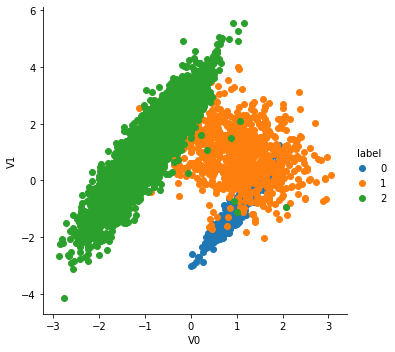

In [4]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_tot, y_tot, test_size=0.2, random_state=7)
X,y=X_train,y_train
print(Counter(y))
scatter(X,y)

In [5]:
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

def simple_test(X_train,y_train,X_test=X_test,y_test=y_test,model='xgboost',regular=[0.1,1,10],depth=[1,5,10]):
    test_scores=[]
    for i in range(len(regular)):
        if model=='logit':
            params=regular
            clf=LogisticRegression(C=params[i],solver='lbfgs',multi_class='auto')
        elif model=='svm':
            params=regular
            clf=SVC(C=params[i],gamma='auto')
        elif model=='knn':
            params=depth
            clf=KNeighborsClassifier(n_neighbors=params[i]) 
        else:
            params=depth
            clf=XGBClassifier(max_depth=params[i])             
            
        clf.fit(X_train,y_train)
        y_pred=clf.predict(X_test)
        test_scores.append(accuracy_score(y_test,y_pred))

    plt.plot(params,test_scores,label=model)
    plt.legend()

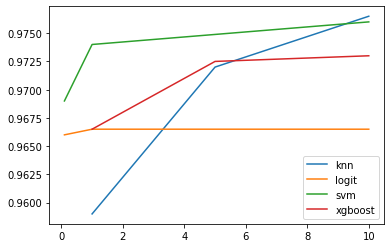

In [6]:
simple_test(X,y,model='knn')
simple_test(X,y,model='logit')
simple_test(X,y,model='svm')
simple_test(X,y,model='xgboost')

We will use svm as our basic model.

## Naive Random over sample 

In [7]:
def sampling(X,y,model):    
    X_resampled, y_resampled = model.fit_sample(X, y)
    print(sorted(Counter(y_resampled).items()))
    scatter(X_resampled, y_resampled)

- This method add new samples randomly chosen from original category with fewer samples.

Using TensorFlow backend.


[(0, 6740), (1, 6740), (2, 6740)]


<Figure size 864x360 with 0 Axes>

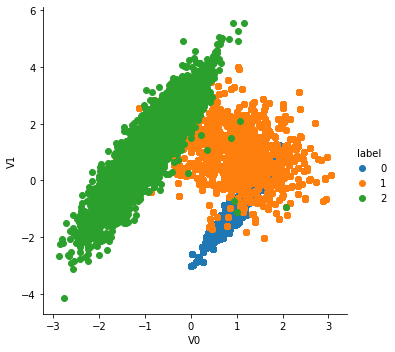

In [8]:
# imblearn is a package for dealing with imbalanced dataset
from imblearn.over_sampling import RandomOverSampler

model = RandomOverSampler(random_state=0)
sampling(X,y,model)

## SMOTE 

- SMOTE: Synthetic Minority Over-sampling Technique

- For any sample A in a minority category, randomly choose a neighbor B, then find a new point on the line of AB as new sample in the category.

[(0, 6740), (1, 6740), (2, 6740)]


<Figure size 864x360 with 0 Axes>

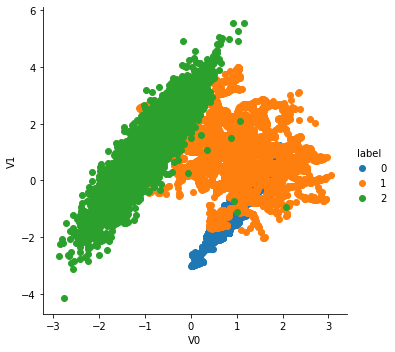

In [9]:
from imblearn.over_sampling import SMOTE, ADASYN
 
model = SMOTE()
sampling(X,y,model)

SMOTE focused on all the minority samples, so it may lead to sub-optimal loss function. One method for improvement is to focus on the boundary of loss function and generate new samples in the opposite direction.

[(0, 6740), (1, 6740), (2, 6740)]


<Figure size 864x360 with 0 Axes>

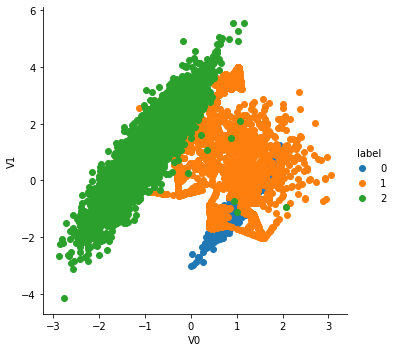

In [10]:
model = SMOTE(kind='borderline1')
sampling(X,y,model)

- 1. SMOTE: kind='regular', randomly choose sample B

- 2. SMOTE: kind='borderline1', neighbor sample B from a different class  

- 3. SMOTE: kind='borderline2', neighbor sample B from any class

- 4. SMOTE: kind='svm', use SVM to generate support vectors, then generate new samples near the vectors

## ADASYN 

- ADASYN: Adaptive Synthetic

- Generate new samples near the minority samples which are classified wrongly by KNN.

[(0, 6725), (1, 6738), (2, 6740)]


<Figure size 864x360 with 0 Axes>

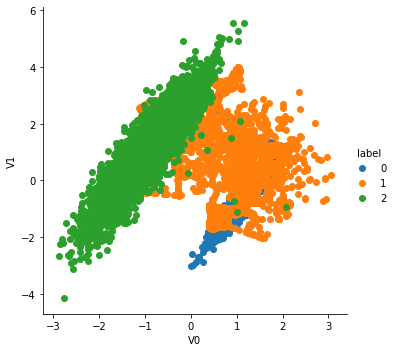

In [11]:
model=ADASYN()
sampling(X,y,model)

# Under-sampling

## prototype generation

- For any given dataset, Prototype Generation generates new data according to original dataset to reduce the size.

- ClusterCentroids use K-Means to generate new samples.

[(0, 427), (1, 427), (2, 427)]


<Figure size 864x360 with 0 Axes>

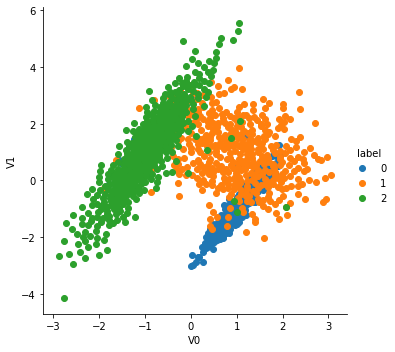

In [12]:
from imblearn.under_sampling import ClusterCentroids
 
model = ClusterCentroids(random_state=0)
sampling(X,y,model)

## prototype selection

- For any given dataset, Prototype Generation select data from original dataset to reduce the size.

### Controlled under-sampling techniques

- RandomUnderSampler randomly choose samples from majority class to balance different classes. When we set replacement=True, it can realize bootstrap sampling.

[(0, 427), (1, 427), (2, 427)]


<Figure size 864x360 with 0 Axes>

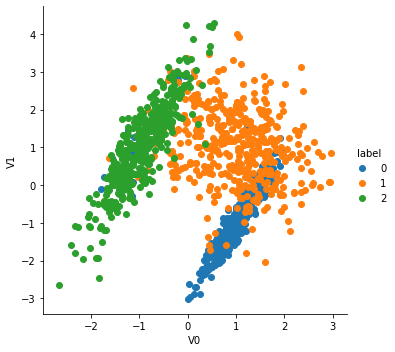

In [13]:
from imblearn.under_sampling import RandomUnderSampler

model = RandomUnderSampler(random_state=0,replacement=False)
sampling(X,y,model)

### Cleaning under-sampling techniques

- EditedNearestNeighbours use KNN to remove samples which are wrongly classified. 

[(0, 427), (1, 575), (2, 6435)]


<Figure size 864x360 with 0 Axes>

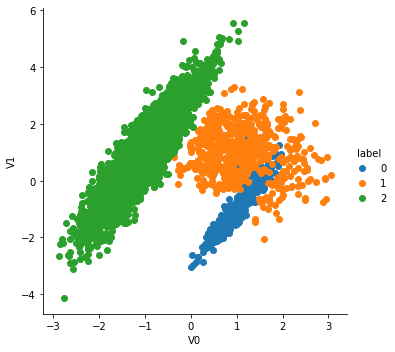

In [14]:
from imblearn.under_sampling import EditedNearestNeighbours
enn = EditedNearestNeighbours(random_state=0)
sampling(X,y,enn)

- RepeatedEditedNearestNeighbours is a repetition of EditedNearestNeighbours for many times.

[(0, 427), (1, 543), (2, 6412)]


<Figure size 864x360 with 0 Axes>

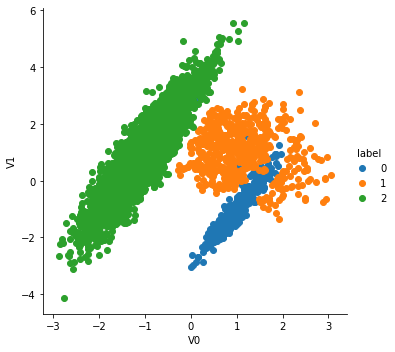

In [15]:
from imblearn.under_sampling import RepeatedEditedNearestNeighbours
renn = RepeatedEditedNearestNeighbours(random_state=0)
sampling(X,y,renn)

- Compared with RepeatedEditedNearestNeighbours, ALLKNN increases samples in each iteration.

[(0, 427), (1, 583), (2, 6560)]


<Figure size 864x360 with 0 Axes>

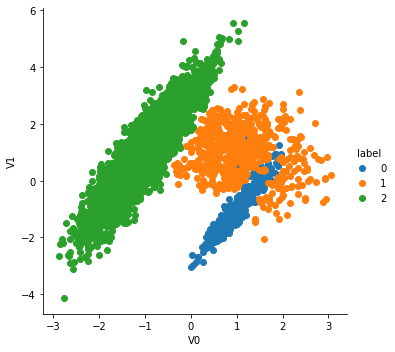

In [16]:
from imblearn.under_sampling import AllKNN
allknn = AllKNN(random_state=0)
sampling(X,y,allknn)

### EasyEnsemble

- EasyEnsemble ensembles data sets by randomly under-sampling the original data set into subsets.

[(0, 427), (1, 427), (2, 427)]


C:\Users\Administrator\AppData\Roaming\Python\Python36\site-packages\sklearn\utils\deprecation.py:66: DeprecationWarning: Class EasyEnsemble is deprecated; EasyEnsemble is deprecated in 0.4 and will be removed in 0.6. Use EasyEnsembleClassifier instead.
  warnings.warn(msg, category=DeprecationWarning)


<Figure size 864x360 with 0 Axes>

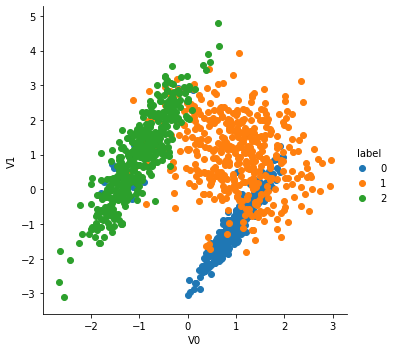

<Figure size 864x360 with 0 Axes>

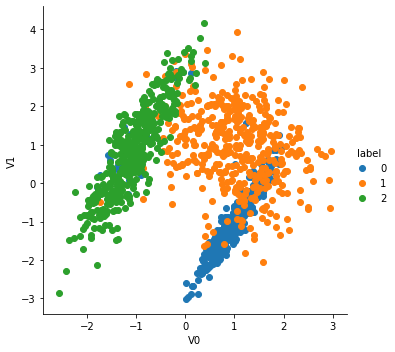

In [17]:
from imblearn.ensemble import EasyEnsemble
ee = EasyEnsemble(random_state=0, n_subsets=10)
X_resampled, y_resampled = ee.fit_sample(X, y)
print(sorted(Counter(y_resampled[0]).items()))
scatter(X_resampled[0], y_resampled[0])
scatter(X_resampled[1], y_resampled[1])

- BalanceCascade utilize an estimator to ensure those wrongly classified samples are selected in the next iteration.

C:\Users\Administrator\AppData\Roaming\Python\Python36\site-packages\sklearn\utils\deprecation.py:66: DeprecationWarning: Class BalanceCascade is deprecated; BalanceCascade is deprecated in 0.4 and will be removed in 0.6.
  warnings.warn(msg, category=DeprecationWarning)


[(0, 427), (1, 427), (2, 427)]


<Figure size 864x360 with 0 Axes>

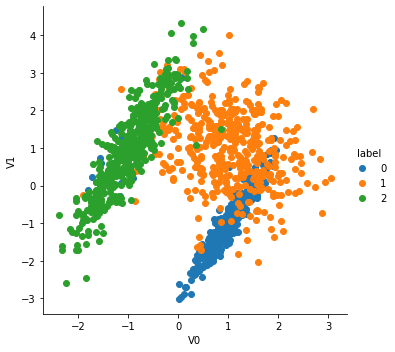

<Figure size 864x360 with 0 Axes>

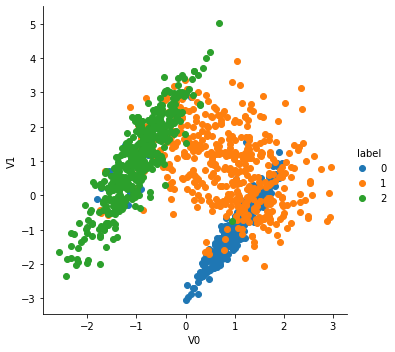

In [18]:
from imblearn.ensemble import BalanceCascade
from sklearn.linear_model import LogisticRegression
bc = BalanceCascade(random_state=0,
                    estimator=LogisticRegression(solver='lbfgs',multi_class='auto'),
                    n_max_subset=4)
X_resampled, y_resampled = bc.fit_sample(X, y)
print(sorted(Counter(y_resampled[0]).items()))
scatter(X_resampled[0], y_resampled[0])
scatter(X_resampled[1], y_resampled[1])

# Over-sampling+ Under-sampling

- In the previous SMOTE methods, new samples near boundary are likely to be noise. Therefore, we can clean the data using under-sampling methods such as EditedNearestNeighbours. 

- SMOTEENN is a combination of SMOTE and EditedNearestNeighbours.

## SMOTEENN

[(0, 6094), (1, 5872), (2, 5453)]


<Figure size 864x360 with 0 Axes>

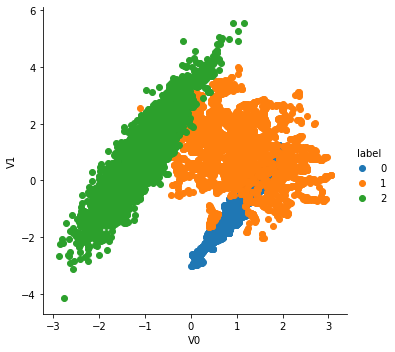

In [19]:
from imblearn.combine import SMOTEENN
smote_enn = SMOTEENN(random_state=0)

sampling(X,y,smote_enn)

- Other methods like SMOTETomek are also widely used.